In [3]:
import json
import os

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

os.chdir('../code')
import evaluate
os.chdir('..')

%matplotlib inline

In [4]:
with open('data/dev-v1.1.json', 'r') as f:
    devdata = json.load(f)['data']

In [5]:
with open('predictions.json', 'r') as f:
    predictions = json.load(f)

### Main Analysis Loop

In [16]:
data = []
for article in devdata:
    for paragraph in article['paragraphs']:
        for question in paragraph['qas']:
            row_data = dict()
            row_data['Qid'] = question['id']
            if row_data['Qid'] not in predictions:
                row_data['Missing'] = True
            else:
                ground_truths = list(map(lambda x: x['text'], question['answers']))
                prediction = predictions[row_data['Qid']]
                question_raw(row_data, question)
                question_type(row_data, question)
                question_length(row_data, question)
                paragraph_length(row_data, paragraph)
                prediction_length(row_data, prediction)
                answer_length(row_data, question)
                exact_match(row_data, question, prediction, ground_truths)
                f1(row_data, question, prediction, ground_truths)
                align_error_type(row_data, paragraph, question, prediction)
            data.append(row_data)
df = pd.DataFrame(data)

### Each function defines a different analysis datapoint

In [7]:
def question_raw(row_data, question):
    row_data['QText'] = question['question']

In [8]:
def question_type(row_data, question):
    if 'who' in question['question'].lower():
        row_data['QType'] = 'WHO'
    elif 'what' in question['question'].lower():
        row_data['QType'] = 'WHAT'
    elif 'which' in question['question'].lower():
        row_data['QType'] = 'WHICH'
    elif 'where' in question['question'].lower():
        row_data['QType'] = 'WHERE'
    elif 'when' in question['question'].lower():
        row_data['QType'] = 'WHEN'
    elif 'why' in question['question'].lower():
        row_data['QType'] = 'WHY'
    elif 'how' in question['question'].lower():
        row_data['QType'] = 'HOW'
    elif 'or' in question['question'].lower():
        row_data['QType'] = 'OPTION'
    else:
        row_data['QType'] = 'OTHER'

In [9]:
def exact_match(row_data, question, prediction, ground_truths):
    row_data['exact_match'] = (
        evaluate.metric_max_over_ground_truths(
            evaluate.exact_match_score, prediction['text'], ground_truths) > 0)

In [10]:
def f1(row_data, question, prediction, ground_truths):
    row_data['f1'] = (
        evaluate.metric_max_over_ground_truths(
            evaluate.f1_score, prediction['text'], ground_truths))

In [11]:
def align_error_type(row_data, paragraph, question, prediction):
    f1, closest_gt = max([(evaluate.f1_score(prediction['text'], ans['text']), ans)
                          for ans in question['answers']])
    if f1 == 0:
        row_data['align_error'] = 'X'
        return
    if f1 == 1:
        row_data['align_error'] = '| |'
        return
    qt_start = closest_gt['answer_start']
    qt_end = qt_start + len(closest_gt['text'].split()) - 1
    pred_start = prediction['pred_start']
    pred_end = pred_start + len(prediction['text'].split()) - 1
    if pred_start == -1 or qt_start == -1:
        row_data['align_error'] = 'bad'
        return
    pref = '< ' if pred_start < qt_start else '> ' if pred_start > qt_start else '| '
    suff = ' <' if pred_end < qt_end else ' >' if pred_end > qt_end else ' |'
    row_data['align_error'] = pref + suff

In [12]:
def question_length(row_data, question):
    row_data['question_len'] = len(question['question'].split(' '))

In [13]:
def paragraph_length(row_data, paragraph):
    row_data['context_len'] = len(paragraph['context'].split(' '))

In [14]:
def answer_length(row_data, question):
    row_data['answer_len'] = len(np.random.choice(question['answers'])['text'].split())

In [15]:
def prediction_length(row_data, prediction):
    row_data['pred_len'] = len(evaluate.normalize_answer(prediction['text']).split())

### Analysis of Result

##### 1. Who / What / Where / When / Why / How

In [23]:
# DISTRIBUTION OF QUESTION TYPES FOR ALL QUESTIONS IN THE DEV SET
table_1 = df.QType.value_counts().to_frame()
table_1.columns = ['Total']
table_1['TotalFrac'] = table_1.Total / table_1.Total.sum()
# DISTRIBUTION OF CORRECT PREDICTIONS BY QUESTION TYPE
table_1['ExactMatch'] = df.groupby('QType')['exact_match'].sum().astype('int')
table_1['ExactMatchFrac'] = table_1['ExactMatch'] / df.QType.value_counts()
#table_1['ExactMatchContrib'] = table_1['TotalFrac'] * table_1['ExactMatchFrac']
table_1['F1_Mean'] = df.groupby('QType')['f1'].mean()
table_1

,Total,TotalFrac,ExactMatch,ExactMatchFrac,F1_Mean
WHAT,5938,0.561779,3762,0.633547,0.742184
WHO,1377,0.130274,976,0.708787,0.774868
HOW,1165,0.110218,782,0.671245,0.765036
WHEN,700,0.066225,587,0.838571,0.875219
WHICH,679,0.064238,465,0.684831,0.775562
WHERE,471,0.044560,293,0.622081,0.741460
WHY,150,0.014191,65,0.433333,0.696251
OPTION,51,0.004825,17,0.333333,0.634620
OTHER,39,0.003690,17,0.435897,0.616582


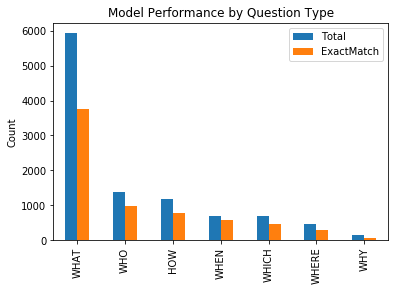

In [27]:
table_1[['Total', 'ExactMatch']].drop(['OPTION', 'OTHER']).plot.bar()
plt.title('Model Performance by Question Type')
plt.ylabel('Count');

Lol, what are the "other" questions? "To whom ..."?

In [67]:
df[df.QType == 'OTHER'].QText.head(10)

28              The name of the NFL championship game is?
196       Whic Carolina Panthers running back was waived?
1252              Did Tesla graduate from the university?
1893    Name a text that might be used by a religious ...
2884    Can BSkyB veto the presence of channels on the...
2885    Does BSkyB carry any control over a channels c...
2886    Does BSkyB carry any control over the picture ...
2908    Does the new deal include Video on demand and ...
3222    The practice of occupying and looting Huguenot...
3483       Oxygen is released in cellular respiration by?
Name: QText, dtype: object

Okay, we'll let these slide...

##### 2. Align Errors

Ignore this for now, this is being a real pain.

In [160]:
df.align_error.value_counts()

| |     6964
X       1674
<  <     701
>  >     697
|  >     214
|  <     181
>  <      43
<  >      41
bad       20
>  |      17
<  |      11
|  |       7
Name: align_error, dtype: int64

##### 3. Question / Paragraph / Prediction Length Considerations

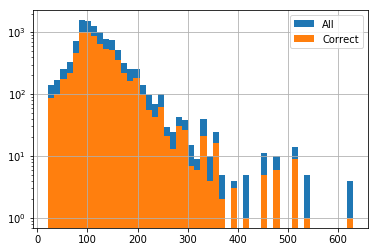

In [189]:
df.context_len.hist(bins=50, alpha=1., log=True, label='All')
df[df.exact_match].context_len.hist(bins=50, alpha=1., log=True, label='Correct').legend();

**Summary:** We score just about the same fraction of predictions correct regardless of context length.

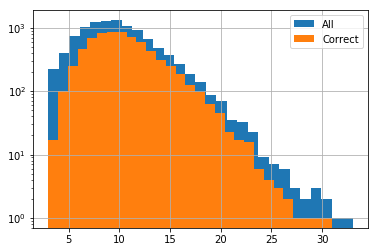

In [184]:
df.question_len.hist(bins=29, alpha=1., log=True, label='All')
df[df.exact_match].question_len.hist(bins=29, alpha=1., log=True, label='Correct').legend();

**Summary:** Our model struggles with small questions ( < 7 words) and very large questions ( > 27 words). Are sweet spot is 10-20 words.

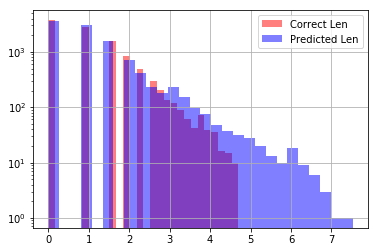

In [32]:
np.log2(df.answer_len).hist(bins=28, log=True, alpha=0.5, label='Correct Len', color='r')
np.log2(df.pred_len).hist(bins=28, log=True, alpha=0.5, label='Predicted Len', color='b').legend();